In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_1000.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell'

# Set data info
DS_LIST = ['canogamez', 'nathan']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['tms_droplet'] = {'species': 'mmusculus', 'dname': 'TMS droplet'}
DIC_INFO['ts_facs'] = {'species': 'hsapiens', 'dname': 'TS FACS'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Cano-Gamez & Soskic et al.'}
DIC_INFO['nathan'] = {'species': 'hsapiens', 'dname': 'Nathan et al.'}

# Set score file
DIC_SCORE_PATH = {'canogamez': [DATA_PATH+'/score_file/score.canogamez_with_cov.magma_10kb_1000'],
                  'nathan': [DATA_PATH+'/score_file/score.nathan_ni_2021_b0_with_cov.magma_10kb_1000',
                             DATA_PATH+'/score_file/score.nathan_ni_2021_b1_with_cov.magma_10kb_1000',
                             DATA_PATH+'/score_file/score.nathan_ni_2021_b2_with_cov.magma_10kb_1000',
                             DATA_PATH+'/score_file/score.nathan_ni_2021_b3_with_cov.magma_10kb_1000'
                            ],
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['canogamez'] = ['PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017',
                              'PASS_Rheumatoid_Arthritis', 'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL', 
                              'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
                              'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
                              'UKB_460K.disease_ASTHMA_DIAGNOSED', 
                              'UKB_460K.disease_RESPIRATORY_ENT',
                              'UKB_460K.body_HEIGHTz']
DIC_TRAIT_LIST['nathan'] = DIC_TRAIT_LIST['canogamez'].copy()

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['canogamez'] = dl.load_canogamez(DATA_PATH)
dic_data_raw['canogamez'].obs['cell_ontology_class'] = dic_data_raw['canogamez'].obs['cluster.id'].copy()
dic_data_raw['nathan'] = dl.load_nathan(DATA_PATH)
dic_data_raw['nathan'].obs['cell_ontology_class'] = dic_data_raw['nathan'].obs['cluster_name'].copy()

# dic_data_proc = {}
# dic_data_proc['canogamez'] = dl.load_canogamez(DATA_PATH, opt='processed')
# dic_data_proc['canogamez'].obs['cell_ontology_class'] = dic_data_proc['canogamez'].obs['cluster.id']
# dic_data_raw['nathan'] = dl.load_nathan(DATA_PATH, opt='processed')

In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
dic_cell_batch = {x:{} for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        temp_df = pd.DataFrame()
        for score_path in DIC_SCORE_PATH[score]:
            file_path = score_path+'/%s.score.gz'%trait
            if os.path.exists(file_path):
                temp_df_batch = pd.read_csv(file_path, sep='\t', index_col=0)
                temp_df_batch.columns = ['%s.%s'%(trait,x) for x in temp_df_batch.columns]
                temp_df_batch['%s.fdr'%trait] = multipletests(temp_df_batch['%s.pval'%trait], method='fdr_bh')[1]
                dic_cell_batch[score][score_path.split('/')[-1]] = list(temp_df_batch.index)
                temp_df = pd.concat([temp_df, temp_df_batch], axis=0)
            else:
                print('# missing: %s'%file_path)        
        dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = sorted(set(dic_data_raw[ds].obs_names) & set(dic_score[ds].index))

In [5]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        dic_ctrl_score[score][trait] = pd.DataFrame()
        for score_path in DIC_SCORE_PATH[score]:
            file_path = score_path+'/%s.full_score.gz'%trait
            if os.path.exists(file_path):
                print('# Loading %s %s'%(score, trait))
                temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
                dic_ctrl_score[score][trait] = pd.concat([dic_ctrl_score[score][trait], temp_df], axis=0)
            else:
                print('# missing: %s'%file_path)

# Loading canogamez PASS_IBD_deLange2017
# Loading canogamez PASS_CD_deLange2017
# Loading canogamez PASS_UC_deLange2017
# Loading canogamez PASS_Rheumatoid_Arthritis
# Loading canogamez PASS_Multiple_sclerosis
# Loading canogamez UKB_460K.disease_AID_ALL
# Loading canogamez UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
# Loading canogamez UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
# Loading canogamez UKB_460K.disease_ASTHMA_DIAGNOSED
# Loading canogamez UKB_460K.disease_RESPIRATORY_ENT
# Loading canogamez UKB_460K.body_HEIGHTz
# Loading nathan PASS_IBD_deLange2017
# Loading nathan PASS_IBD_deLange2017
# Loading nathan PASS_IBD_deLange2017
# Loading nathan PASS_IBD_deLange2017
# Loading nathan PASS_CD_deLange2017
# Loading nathan PASS_CD_deLange2017
# Loading nathan PASS_CD_deLange2017
# Loading nathan PASS_CD_deLange2017
# Loading nathan PASS_UC_deLange2017
# Loading nathan PASS_UC_deLange2017
# Loading nathan PASS_UC_deLange2017
# Loading nathan PASS_UC_deLange2017
# Loading nathan PASS_Rh

### Cell-type trait association 

In [28]:
# Full data rseults 
dic_stats = {}
for ds in DS_LIST:
    print(ds)
    score = ds
    celltype_list = sorted(set(dic_data_raw[ds].obs['cell_ontology_class']))
    trait_list = DIC_TRAIT_LIST[ds]
    dic_stats[ds] = pd.DataFrame(index=celltype_list, columns=trait_list, dtype=float)
    for trait in trait_list:
        for ct in celltype_list:
            cell_list = dic_data_raw[ds].obs_names[dic_data_raw[ds].obs['cell_ontology_class']==ct]
            score_q95 = np.quantile(dic_score[score].loc[cell_list, '%s.norm_score'%trait], 0.95)
            temp_df = dic_ctrl_score[score][trait].loc[cell_list].loc[cell_list].copy()
            temp_df = temp_df[[x for x in temp_df.columns if x.startswith('ctrl_norm_score')]]
            v_ctrl_score_q95 = np.quantile(temp_df, 0.95, axis=0)
            dic_stats[ds].loc[ct,trait] = ((v_ctrl_score_q95>=score_q95).sum()+1) / (v_ctrl_score_q95.shape[0]+1)
            
# Per-batch results
dic_stats_batch = {}
for ds in DS_LIST:
    score = ds
    celltype_list = sorted(set(dic_data_raw[ds].obs['cell_ontology_class']))
    trait_list = DIC_TRAIT_LIST[ds]
    dic_stats_batch[ds] = {x:pd.DataFrame(index=celltype_list, columns=trait_list, dtype=float) 
                           for x in dic_cell_batch[ds]}
    if len(dic_cell_batch[ds])==1:
        dic_stats_batch[ds][list(dic_cell_batch[ds].keys())[0]] = dic_stats[ds]
    else:
        for batch_name in dic_cell_batch[ds]:
            print(ds, batch_name)
            for trait in trait_list:
                for ct in celltype_list:
                    cell_list = dic_data_raw[ds].obs_names[dic_data_raw[ds].obs['cell_ontology_class']==ct]
                    cell_list = sorted(set(cell_list) & set(dic_cell_batch[ds][batch_name]))
                    score_q95 = np.quantile(dic_score[score].loc[cell_list, '%s.norm_score'%trait], 0.95)
                    temp_df = dic_ctrl_score[score][trait].loc[cell_list].loc[cell_list].copy()
                    temp_df = temp_df[[x for x in temp_df.columns if x.startswith('ctrl_norm_score')]]
                    v_ctrl_score_q95 = np.quantile(temp_df, 0.95, axis=0)
                    dic_stats_batch[ds][batch_name].loc[ct,trait] = ((v_ctrl_score_q95>=score_q95).sum()+1) /\
                        (v_ctrl_score_q95.shape[0]+1)
                    
# Results for subsampling 4x
dic_stats_subsample = {}
for ds in DS_LIST:
    print(ds)
    np.random.seed(10) # Cannot be 0, which replicates the b0 cell_list 
    cell_list_subsample = np.random.choice(dic_data_raw[ds].obs_names, size=int(dic_data_raw[ds].shape[0]/4),
                                           replace=False)
    score = ds
    celltype_list = sorted(set(dic_data_raw[ds].obs['cell_ontology_class']))
    trait_list = DIC_TRAIT_LIST[ds]
    dic_stats_subsample[ds] = pd.DataFrame(index=celltype_list, columns=trait_list, dtype=float)
    for trait in trait_list:
        for ct in celltype_list:
            cell_list = dic_data_raw[ds].obs_names[dic_data_raw[ds].obs['cell_ontology_class']==ct]
            cell_list = sorted(set(cell_list) & set(cell_list_subsample))
            score_q95 = np.quantile(dic_score[score].loc[cell_list, '%s.norm_score'%trait], 0.95)
            temp_df = dic_ctrl_score[score][trait].loc[cell_list].loc[cell_list].copy()
            temp_df = temp_df[[x for x in temp_df.columns if x.startswith('ctrl_norm_score')]]
            v_ctrl_score_q95 = np.quantile(temp_df, 0.95, axis=0)
            dic_stats_subsample[ds].loc[ct,trait] = ((v_ctrl_score_q95>=score_q95).sum()+1) /\
                (v_ctrl_score_q95.shape[0]+1)

canogamez
nathan
nathan score.nathan_ni_2021_b0_with_cov.magma_10kb_1000
nathan score.nathan_ni_2021_b1_with_cov.magma_10kb_1000
nathan score.nathan_ni_2021_b2_with_cov.magma_10kb_1000
nathan score.nathan_ni_2021_b3_with_cov.magma_10kb_1000


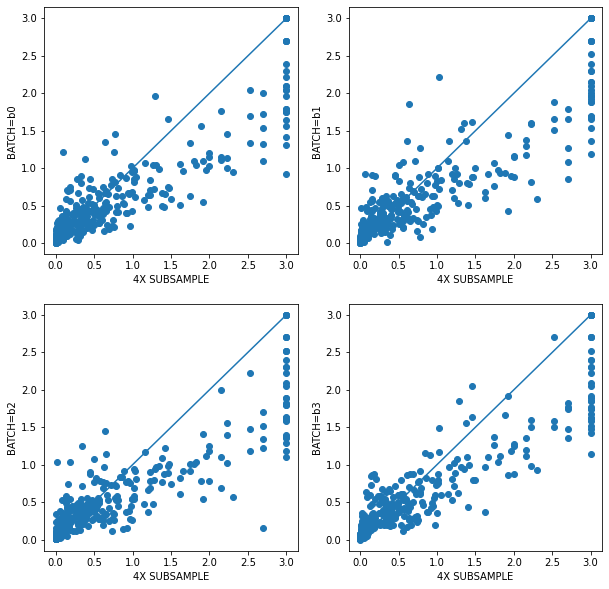

In [138]:
# Comparison of full results and batch results and subsample results 
ds = 'nathan'
plt.figure(figsize=[10,10])
for i,batch_name in enumerate(dic_stats_batch[ds].keys()):
    plt.subplot(2,2,i+1)
    v1 = dic_stats_subsample[ds].values.flatten()
    v2 = dic_stats_batch[ds][batch_name].values.flatten()
    plt.scatter(-np.log10(v1), -np.log10(v2))
    plt.xlabel('4X SUBSAMPLE')
    plt.ylabel('BATCH=%s'%batch_name.split('_')[3])
    plt.plot([0,3], [0,3])
plt.show()

In [166]:
def assign_str(x):
    if x<0.01:
        return '$<$.01'
    elif x<=0.05:
        return ('%0.2f'%x)[1:]
    else:
        return 'ns'

# Results in Cano-Gamez & Soskic et al.
ds = 'canogamez'
col = dic_data_raw[ds].obs.columns[0]
temp_df = dic_data_raw[ds].obs.groupby(['cell_ontology_class']).agg({col:len})
display(temp_df)
celltype_list = sorted(temp_df.index)
print('n_celltype=%d'%len(celltype_list), ', '.join(celltype_list))

# Get p-values
df_stats = dic_stats[ds].loc[celltype_list].copy()
df_stats_fdr = df_stats.copy()

# Multiple testing: applied to all cell type-disease pairs 
# df_stats_fdr.loc[:,:] = multipletests(df_stats_fdr.values.flatten(), method='fdr_bh')[1].reshape(df_stats_fdr.shape)
for col in df_stats_fdr:
    df_stats_fdr[col] = multipletests(df_stats_fdr[col], method='fdr_bh')[1]

# Make table 
df_res = df_stats_fdr.loc[(df_stats_fdr<0.05).sum(axis=1)>0].copy()
df_res.columns = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.columns]
for col in df_res:
    df_res[col] = [assign_str(x) for x in df_res[col]]
df_res.index.name = DIC_INFO[ds]['dname']
print(df_res.to_latex(index_names=True, escape=False))

,cell.type
cell_ontology_class,
HSP.high,1174
IFN.high,1318
Mitotic,1650
TCM1 (Th0),1909
TCM1 (Th17/iTreg),1041
TCM2 (Th0),2596
TCM2 (Th17/iTreg),3860
TCM (resting),1915
TEM (Th0),1297


n_celltype=22 HSP.high, IFN.high, Mitotic, TCM (resting), TCM1 (Th0), TCM1 (Th17/iTreg), TCM2 (Th0), TCM2 (Th17/iTreg), TEM (Th0), TEM (Th17/iTreg), TEM (resting), TEMRA (Th0), TEMRA (Th17/iTreg), TEMRA (resting), TN (Th0), TN (Th17), TN (Th17/iTreg), TN (Th2), TN (iTreg), TN (resting), nTreg (Th0), nTreg (resting)
\begin{tabular}{llllllllllll}
\toprule
{} &  IBD &   CD &   UC &   RA &   MS &  AIT &   HT & Eczema & ASM & RR-ENT & Height \\
Cano-Gamez & Soskic et al. &      &      &      &      &      &      &      &        &     &        &        \\
\midrule
TCM1 (Th17/iTreg)          &  .05 &  .05 &   ns &   ns &   ns &  .04 &   ns &    .04 &  ns &     ns &     ns \\
TCM2 (Th0)                 &   ns &  .05 &   ns &   ns &   ns &   ns &   ns &     ns &  ns &     ns &     ns \\
TEM (Th17/iTreg)           &  .01 &  .05 &   ns &   ns &   ns &  .04 &  .02 &     ns &  ns &     ns &     ns \\
TN (Th17/iTreg)            &  .01 &  .03 &  .01 &   ns &   ns &   ns &  .04 &    .01 &  ns &    .02

In [168]:
# Results in Nathan et al. (Combining 4 batches)
ds,score = 'nathan','nathan'
col = dic_data_raw[ds].obs.columns[0]
temp_df = dic_data_raw[ds].obs.groupby(['cell_ontology_class']).agg({col:len})
display(temp_df)
celltype_list = list(temp_df.index[temp_df.index!='nan'])
print('n_celltype=%d'%len(celltype_list), ', '.join(celltype_list))

# Combine p-values using Fisher's method
df_stats_fdr = pd.DataFrame(index=celltype_list, columns=DIC_TRAIT_LIST[ds], dtype=float)
for ct in celltype_list:
    for trait in trait_list:
        df_stats_fdr.loc[ct, trait] = sp.stats.combine_pvalues([dic_stats_batch[ds][x].loc[ct,trait] 
                                                                for x in dic_cell_batch[ds]])[1]

# Multiple testing
# df_stats_fdr.loc[:,:] = multipletests(df_stats_fdr.values.flatten(), method='fdr_bh')[1].reshape(df_stats_fdr.shape)
for col in df_stats_fdr:
    df_stats_fdr[col] = multipletests(df_stats_fdr[col], method='fdr_bh')[1]

# Make table 
df_res = df_stats_fdr.loc[(df_stats_fdr<0.05).sum(axis=1)>0].copy()
df_res.columns = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.columns]
for col in df_res:
    df_res[col] = [assign_str(x) for x in df_res[col]]
df_res.index.name = DIC_INFO[ds]['dname']
df_res.index = [x.replace('+','$^+$') for x in df_res.index]
print(df_res.to_latex(index_names=True, escape=False))

,nUMI
cell_ontology_class,
CD4+ CCR4+,17321
CD4+ CCR4+ central,28951
CD4+ CCR4+ICOS+ central,27770
CD4+ CCR5+ cytotoxic,4241
CD4+ CD27+,40431
CD4+ CD27+CD161+,45519
CD4+ CD38+ICOS+ central,4891
CD4+ CD161+ Th1,17731
CD4+ CD161+ Th2,13662


n_celltype=29 CD4+ CCR4+, CD4+ CCR4+ central, CD4+ CCR4+ICOS+ central, CD4+ CCR5+ cytotoxic, CD4+ CD27+, CD4+ CD27+CD161+, CD4+ CD38+ICOS+ central, CD4+ CD161+ Th1, CD4+ CD161+ Th2, CD4+ CD161+ cytotoxic, CD4+ HLA-DR+, CD4+ RORC+ Treg, CD4+ Th1, CD4+ Th2, CD4+ Th17, CD4+ Th17/1, CD4+ Treg, CD4+ activated, CD4+ central, CD4+ cytotoxic, CD4+ lncRNA, CD4/8+ PD-1+TIGIT+, CD8+ CXCR3+, CD8+ GZMB+, CD8+ GZMK+, CD8+ activated, CD8+ central, Vd1, Vd2
\begin{tabular}{llllllllllll}
\toprule
{} &     IBD &      CD &      UC &      RA &   MS &     AIT &      HT &  Eczema &     ASM &  RR-ENT & Height \\
\midrule
CD4$^+$ CCR4$^+$                 &      ns &      ns &      ns &      ns &   ns &      ns &      ns &  $<$.01 &      ns &      ns &     ns \\
CD4$^+$ CCR4$^+$ICOS$^+$ central &      ns &      ns &     .05 &      ns &   ns &      ns &      ns &     .02 &      ns &      ns &     ns \\
CD4$^+$ CD38$^+$ICOS$^+$ central &      ns &      ns &      ns &  $<$.01 &   ns &      ns &      ns &      ns 

<function scipy.stats.stats.combine_pvalues(pvalues, method='fisher', weights=None)>